### RNN 
[go home](#Content)

|*Type of RNN*|Illustration|Example|
|---|---|---|
|One-to-One|![rnn-one-to-one-ltr](rnn-one-to-one-ltr.png)|Traditional neural network|
|One-to-Many|![rnn-one-to-many-ltr](rnn-one-to-many-ltr.png)|Music Generation|
|Many-to-One|![rnn-many-to-one-ltr](rnn-many-to-one-ltr.png)|Sentiment classification|
|Many-to-Many|![rnn-many-to-many-same-ltr](rnn-many-to-many-same-ltr.png)|Name Entity recognition|
|Many-to-Many|![rnn-many-to-many-different-ltr](rnn-many-to-many-different-ltr.png)|Machine Translation|
|Bidirectional (BRNN)|![bidirectional-rnn-ltr](bidirectional-rnn-ltr.png)|???|
|Deep (DRNN)|![deep-rnn-ltr](deep-rnn-ltr.png)|???|

### build RNN model from scratch

[go home](#Content)

model's type: `many-to-one`

![model_architecture1](many-to-one10.png)

In [1]:
# import required libaries
import time
import math 
import numpy as np
import matplotlib.pyplot as plt

We need set up some `hyperparameters`:
- learning rate
- sequence length
- training epochs
- dimension of hidden layer
- dimension of ouput layer
- how many iterations back we want to fo when doing back propagation
- maximum and minimum values we will allow for our gradients

In [2]:
# hyperparameters
learning_rate = 0.0001
seq_len = 50
max_epochs = 15
hidden_dim = 100
output_dim = 1
bptt_truncate = 5 # backprop through time --> lasts 5 iterations, the number of timestep that we will go back
min_clip_val = -10
max_clip_val = 10

In [3]:
# define activation function
def sigmoid(x):
    return 1/(1+np.exp(-x))

def tanh(x):
    return (np.exp(x) - np.exp(-x))/(np.exp(x) + np.exp(-x))

### Train/test split on Sequence data for RNN

We’ll be training our Recurrent Neural Network on a sine wave. Sine waves are sequence data that oscillate with a period of 2$pi. After getting the sine wave data, we’ll set up our training and testing data. Let’s initialize two empty lists, X for the input sequence data, and Y for the next data point in the sequence.

We’ll set each datapoint of X as 50 contiguous points in the series and each datapoint of Y as the next datapoint in the sine wave. We’ll set the training data to the first 100 points, and the validation data as the next 50. After creating the lists, we’ll turn them into matrices using `np.expand_dims`.

In [4]:
# create dataset
sin_wave = np.array([math.sin(x) for x in range(200)])

# training data
X = []
Y = []
num_records = len(sin_wave) - seq_len # the first 150 element will be training data, the next 50 element will be testing data

# X entries are 50 data points
# Y entries are the 51 data points
for i in range(num_records - 50):
    X.append(sin_wave[i:i+seq_len])
    Y.append(sin_wave[i+seq_len])

In [5]:
X[:2]

[array([ 0.        ,  0.84147098,  0.90929743,  0.14112001, -0.7568025 ,
        -0.95892427, -0.2794155 ,  0.6569866 ,  0.98935825,  0.41211849,
        -0.54402111, -0.99999021, -0.53657292,  0.42016704,  0.99060736,
         0.65028784, -0.28790332, -0.96139749, -0.75098725,  0.14987721,
         0.91294525,  0.83665564, -0.00885131, -0.8462204 , -0.90557836,
        -0.13235175,  0.76255845,  0.95637593,  0.27090579, -0.66363388,
        -0.98803162, -0.40403765,  0.55142668,  0.99991186,  0.52908269,
        -0.42818267, -0.99177885, -0.64353813,  0.29636858,  0.96379539,
         0.74511316, -0.15862267, -0.91652155, -0.83177474,  0.01770193,
         0.85090352,  0.90178835,  0.12357312, -0.76825466, -0.95375265]),
 array([ 0.84147098,  0.90929743,  0.14112001, -0.7568025 , -0.95892427,
        -0.2794155 ,  0.6569866 ,  0.98935825,  0.41211849, -0.54402111,
        -0.99999021, -0.53657292,  0.42016704,  0.99060736,  0.65028784,
        -0.28790332, -0.96139749, -0.75098725,  0

In [6]:
Y[:2]

[-0.26237485370392877, 0.6702291758433747]

In [7]:
X = np.expand_dims(np.array(X),axis = 2)
X[:2]

array([[[ 0.        ],
        [ 0.84147098],
        [ 0.90929743],
        [ 0.14112001],
        [-0.7568025 ],
        [-0.95892427],
        [-0.2794155 ],
        [ 0.6569866 ],
        [ 0.98935825],
        [ 0.41211849],
        [-0.54402111],
        [-0.99999021],
        [-0.53657292],
        [ 0.42016704],
        [ 0.99060736],
        [ 0.65028784],
        [-0.28790332],
        [-0.96139749],
        [-0.75098725],
        [ 0.14987721],
        [ 0.91294525],
        [ 0.83665564],
        [-0.00885131],
        [-0.8462204 ],
        [-0.90557836],
        [-0.13235175],
        [ 0.76255845],
        [ 0.95637593],
        [ 0.27090579],
        [-0.66363388],
        [-0.98803162],
        [-0.40403765],
        [ 0.55142668],
        [ 0.99991186],
        [ 0.52908269],
        [-0.42818267],
        [-0.99177885],
        [-0.64353813],
        [ 0.29636858],
        [ 0.96379539],
        [ 0.74511316],
        [-0.15862267],
        [-0.91652155],
        [-0

In [8]:
Y = np.expand_dims(np.array(Y),axis =1)
print(Y.shape)
print(Y[:2])

(100, 1)
[[-0.26237485]
 [ 0.67022918]]


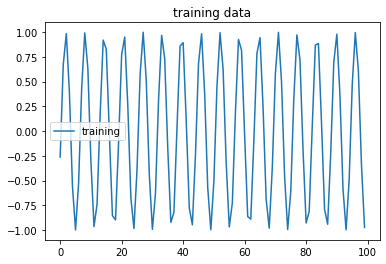

In [9]:
# display training data
plt.plot(range(len(Y)),Y,label = 'training')
plt.title("training data")
plt.legend()

In [10]:
# validation data
X_validation = []
Y_validation = []

for i in range(num_records -seq_len,num_records):
    X_validation.append(sin_wave[i:i+seq_len])
    Y_validation.append(sin_wave[i+seq_len])
    
X_validation = np.expand_dims(np.array(X_validation),axis = 2)
print(f"X_validation: {X_validation.shape}")
Y_validation = np.expand_dims(np.array(Y_validation),axis = 1)
print(f"Y_validation: {Y_validation.shape}")

X_validation: (50, 50, 1)
Y_validation: (50, 1)


Text(0.5, 1.0, 'testing data')

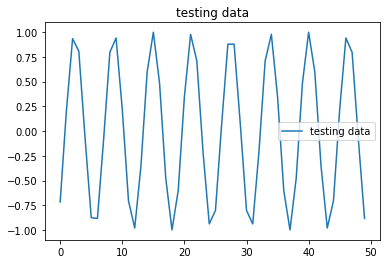

In [11]:
plt.plot(range(len(X_validation)),Y_validation,label = 'testing data')
plt.legend()
plt.title("testing data")

Text(0.5, 1.0, 'full data')

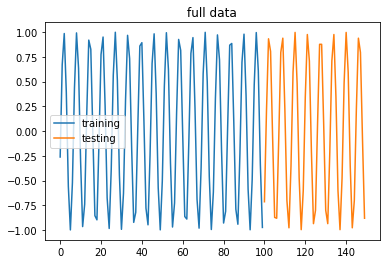

In [12]:
# display full dataset
plt.plot(range(len(X)),Y,label = 'training')
plt.plot(range(len(X),len(X)+len(X_validation)),Y_validation,label = 'testing')
plt.legend()
plt.title("full data")

In [13]:
print(f"X.shape: {X.shape}")
print(f"Y.shape: {Y.shape}")
print(f"X_validation.shape: {X_validation.shape}")
print(f"Y_validation.shape: {Y_validation.shape}")

X.shape: (100, 50, 1)
Y.shape: (100, 1)
X_validation.shape: (50, 50, 1)
Y_validation.shape: (50, 1)


In [14]:
# initialize matrix
np.random.seed(12161)
U = np.random.uniform(0,1,(hidden_dim,seq_len)) # weights from input to hidden layer
V = np.random.uniform(0,1,(output_dim,hidden_dim)) # weights from hidden to ouput layer
W = np.random.uniform(0,1,(hidden_dim,hidden_dim)) # recurrent weights for layer (RNN weights)
print(f"U.shape: {U.shape}")
print(f"V.shape: {V.shape}")
print(f"W.shape : {W.shape}")

U.shape: (100, 50)
V.shape: (1, 100)
W.shape : (100, 100)


In [15]:
def init_matrix(seq_len,hidden_dim,output_dim,random_seed):
    '''
    seq_len --- the lenght of sequences input
    hidden_dim --- number of nodes in hidden layer
    output_dim --- number of ouput 
    random_seed --- numpy random seed
    '''
    np.random.seed(random_seed)
    U = np.random.uniform(0,1,(hidden_dim,seq_len)) # weights from input to hidden layer
    V = np.random.uniform(0,1,(output_dim,hidden_dim)) # weights from hidden to output layer
    W = np.random.uniform(0,1,(hidden_dim,hidden_dim)) # recurrent weights for layer (RNN weights)
    return U,V,W

In [16]:
U,V,W = init_matrix(seq_len,hidden_dim,output_dim,random_seed=12161)
print(f"U.shape: {U.shape}")
print(f"V.shape: {V.shape}")
print(f"W.shape: {W.shape}")

U.shape: (100, 50)
V.shape: (1, 100)
W.shape: (100, 100)


In [17]:
# inspect the loss function
loss = 0.0

for i in range(Y.shape[0]): # from 0-100
    x,y = X[i],Y[i] # x = (50,1),y = (1,)
    prev_activation = np.zeros((hidden_dim,1)) # value of previous activation (100,1)
    for timestep in range(seq_len):
        new_input = np.zeros(x.shape) # (50,1)
        new_input[timestep] = x[timestep] # [0,0,...,x[timestep],...,0,0]
        mul_u = np.dot(U,new_input)
        mul_w = np.dot(W,prev_activation)
        _sum = mul_u + mul_w # (100,1)
        activation = sigmoid(_sum) # (100,1)
        mul_v = np.dot(V,activation) # V = (1,100), activation = (100,1) (1,1) there is no activation in ouput 
        prev_activation = activation # update activation
        # calculate loss per record and accumulate
        loss_per_record = float((y - mul_v)**2/2)
    loss +=loss_per_record

print(f"loss: {loss}")

loss: 132219.50990086797


In [18]:
# define loss function
def calculate_loss(X,Y,U,V,W):
    '''
    arguments:
    X --- all inputs  (no_samples,seq_len,1,1)
    Y --- all ground-truth (labels) (n,1)
    U --- matrix multiply with input x
    W --- matrix multiply with the previous node
    V --- matrix multiply with the current node
    '''
    loss = 0.0
    # loop over each data point
    for i in range(Y.shape[0]):
        x,y = X[i],Y[i] # get the current input (1x50) and output (1)
        prev_activation =  np.zeros((hidden_dim,1)) # value of previous activation
        for timestep in range(seq_len):
            new_input = np.zeros(x.shape) # create a new array input,(1,50,1), forward pass, done for each step
            new_input[timestep] = x[timestep] # define a single input for that timestep
            mul_u = np.dot(U,new_input)
            mul_w = np.dot(W,prev_activation)
            _sum =  mul_u + mul_w
            activation = sigmoid(_sum)
            mul_v = np.dot(V,activation)
            prev_activation = activation
        # calculate and add loss per record
        loss_per_record = float((y - mul_v)**2/2)
        loss += loss_per_record
    # return the last activation
    return loss,activation

In [19]:
loss,activation = calculate_loss(X,Y,U,V,W)
print(f"loss: {loss}")

loss: 132219.50990086797


In [20]:
prev_activation = np.array([0])
print(prev_activation.shape)

(1,)


In [21]:
# takes x values and the weights matrices
# returns layer dictionary final weights (mul_u,mul_w,mul_v)
layers = []
prev_activation = np.zeros((hidden_dim,1)) # the first activation
for timestep in range(seq_len):
    new_input = np.zeros(x.shape) # (50,1) make scilent for every input but the input correctsponding
    new_input[timestep] = x[timestep] # (50,1)
    mul_u = np.dot(U,new_input) # (100,1)
    mul_w = np.dot(W,prev_activation) # (100,1)
    _sum = mul_w + mul_u # (100,1)
    activation = sigmoid(_sum)
    mul_v = np.dot(V,activation) # (1,1)
    prev_activation = activation
    layers.append({'activation':activation,'prev_activation':prev_activation})

In [22]:
def calc_layers(x,U,V,W,prev_activation):
    layers = []
    for timestep in range(seq_len):
        new_input = np.zeros(x.shape)
        new_input[timestep] = x[timestep]
        mul_u = np.dot(U,new_input)
        mul_w = np.dot(W,prev_activation)
        _sum = mul_w + mul_u
        activation = sigmoid(_sum)
        mul_v = np.dot(V,activation)
        layers.append({"activation":activation,'prev_activation':prev_activation})
        prev_activation = activation #
    return layers,mul_u,mul_w,mul_v

### RNN - backpropagation through time

![model_architecture1](many-to-one11.png)


In [23]:
def backprop(x, U, V, W, dmulv, mulu, mulw, layers):
    dU = np.zeros(U.shape)
    dV = np.zeros(V.shape)
    dW = np.zeros(W.shape)
   
    dU_t = np.zeros(U.shape)
    dV_t = np.zeros(V.shape)
    dW_t = np.zeros(W.shape)
   
    dU_i = np.zeros(U.shape)
    dW_i = np.zeros(W.shape)
   
    _sum = mulu + mulw
    dsv = np.dot(np.transpose(V), dmulv)
   
    def get_previous_activation_differential(_sum, ds, W):
        d_sum = _sum * (1 - _sum) * ds
        dmulw = d_sum #* np.ones_like(ds)
        return np.dot(np.transpose(W), dmulw)
   
    for timestep in range(seq_len):
        dV_t = np.dot(dmulv, np.transpose(layers[timestep]['activation']))
        ds = dsv
        dprev_activation = get_previous_activation_differential(_sum, ds, W)
       
        for _ in range(timestep-1, max(-1, timestep-bptt_truncate-1), -1):
            ds = dsv + dprev_activation
            dprev_activation = get_previous_activation_differential(_sum, ds, W)
            dW_i = np.dot(W, layers[timestep]['prev_activation'])
           
            new_input = np.zeros(x.shape)
            new_input[timestep] = x[timestep]
            dU_i = np.dot(U, new_input)
           
            dU_t += dU_i
            dW_t += dW_i
           
        dU += dU_t
        dV += dV_t
        dW += dW_t
       
        # take care of possible exploding gradients
        if dU.max() > max_clip_val:
            dU[dU > max_clip_val] = max_clip_val
        if dV.max() > max_clip_val:
            dV[dV > max_clip_val] = max_clip_val
        if dW.max() > max_clip_val:
            dW[dW > max_clip_val] = max_clip_val
       
        if dU.min() < min_clip_val:
            dU[dU < min_clip_val] = min_clip_val
        if dV.min() < min_clip_val:
            dV[dV < min_clip_val] = min_clip_val
        if dW.min() < min_clip_val:
            dW[dW < min_clip_val] = min_clip_val
       
    return dU, dV, dW

That is so weird because even your calculate is not really true but somehow your model is still learnable

Ex:
```
 dW_i = dmulv @ V @ W @ layers[timestep]['prev_activation']
```
vs
```
 dW_i = W @ layers[timestep]['prev_activation']
```

 but the loss will be smaller and your model can learn deeper if your calculation is true

In [24]:
def my_backprop(x, U, V, W, dmulv, mulu, mulw, layers):
    dU = np.zeros(U.shape)
    dV = np.zeros(V.shape)
    dW = np.zeros(W.shape)
    
    dU_t = np.zeros(U.shape)
    dV_t = np.zeros(V.shape)
    dW_t = np.zeros(W.shape)
    
    dU_i = 0.0
    dW_i = 0.0
    
    for timestep in range(seq_len):
        # differential of V in each layer at timestep
        dV_t = dmulv @ layers[timestep]['activation'].T #np.dot(dmulv, np.transpose(layers[timestep]['activation']))
        
        for _ in range(timestep-1, max(-1, timestep-bptt_truncate-1), -1):
            # differential of W for truncated backpropagation through time
            dW_i = np.dot(W, layers[timestep]['prev_activation'])
            # print(f'dW_i:{dW_i.shape}')
            # print(f'dW_i: {dW_i.shape}')
            # differential of U for truncated backpropagation through time
            new_input = np.zeros(x.shape)
            new_input[timestep] = x[timestep]
            dU_i = np.dot(U, new_input)
            # print(f'dU_i:{dU_i.shape}')
            # print(f'dU_i: {dU_i.shape}')
            # differential of U,W  in each layer at timestep
            dU_t += dU_i
            dW_t += dW_i
        # differentials in each layer
        # print(f'dW_t:{dW_t.shape}')
        # print(f'dU_t:{dU_t.shape}')
        # print(f'dW:{dW.shape}')
        # print(f'dU:{dU.shape}')
        dU += dU_t
        dV += dV_t
        dW += dW_t
        
        # take care of possible exploding gradients
        if dU.max() > max_clip_val:
            dU[dU > max_clip_val] = max_clip_val
        if dV.max() > max_clip_val:
            dV[dV > max_clip_val] = max_clip_val
        if dW.max() > max_clip_val:
            dW[dW > max_clip_val] = max_clip_val
        
        if dU.min() < min_clip_val:
            dU[dU < min_clip_val] = min_clip_val
        if dV.min() < min_clip_val:
            dV[dV < min_clip_val] = min_clip_val
        if dW.min() < min_clip_val:
            dW[dW < min_clip_val] = min_clip_val
        
    return dU, dV, dW

In [25]:
# training
start_time = time.time()

# initialize matrix
U,V,W = init_matrix(seq_len,hidden_dim,output_dim,random_seed=12161)
print(f"U.shape: {U.shape}")
print(f"V.shape: {V.shape}")
print(f"W.shape: {W.shape}")

# calculate initial loss
train_loss,activation = calculate_loss(X,Y,U,V,W)
print(f"train_loss: {train_loss}")

# check validation loss
val_loss,_ = calculate_loss(X_validation,Y_validation,U,V,W)
print(f"val_loss: {val_loss}")

# forward
for i in range(Y.shape[0]):
    x,y = X[i],Y[i] # x (50,1), y(1,)
    layers = []
    prev_activation = np.zeros((hidden_dim,1))
    layers,mul_u,mul_w,mul_v = calc_layers(x,U,V,W,prev_activation)
    # difference of the prediction
    dmulv = mul_v - y
    #print(f"dmulv")
    dU,dV,dW = my_backprop(x,U,V,W,dmulv,mul_u,mul_w,layers)
    # update weights
    U -= learning_rate * dU
    V -= learning_rate * dV
    W -= learning_rate * dW

finish_time = time.time()

print(f"time consuming: {finish_time - start_time}")

U.shape: (100, 50)
V.shape: (1, 100)
W.shape: (100, 100)
train_loss: 132219.50990086797
val_loss: 66107.73179592531
time consuming: 2.9091663360595703


In [26]:
def train(U,V,W,X,Y,X_validation,Y_validation):
    loss_curve = []
    for epoch in range(max_epochs):
        # calculate initial loss, ie what the output is given a random set of weights
        loss,prev_activation = calculate_loss(X,Y,U,V,W)
        loss_curve.append(loss)
        # check validation loss
        val_loss,_ = calculate_loss(X_validation,Y_validation,U,V,W)
        print(f"Epoch: {epoch+1},Loss: {loss},Validation_loss: {val_loss}")
        # train model/ forward pass
        for i in range(Y.shape[0]):
            x,y = X[i],Y[i]
            layers = []
            prev_activation = np.zeros((hidden_dim,1))
            layers,mul_u,mul_w,mul_v = calc_layers(x,U,V,W,prev_activation)
            # difference of the prediction
            dmulv =mul_v - y
            dU,dV,dW = my_backprop(x,U,V,W,dmulv,mul_u,mul_w,layers)
            # update weights
            U -= learning_rate * dU
            V -= learning_rate * dV
            W -= learning_rate * dW
    return U,V,W,loss_curve

Epoch: 1,Loss: 85800.72307067864,Validation_loss: 42898.72415489228
Epoch: 2,Loss: 49381.93624027209,Validation_loss: 24689.71651375042
Epoch: 3,Loss: 22963.14709973055,Validation_loss: 11480.707715186478
Epoch: 4,Loss: 6528.960175424226,Validation_loss: 3263.9837277981487
Epoch: 5,Loss: 73.48484896852837,Validation_loss: 36.64889565546561
Epoch: 6,Loss: 35.64325682310044,Validation_loss: 17.753583029462952
Epoch: 7,Loss: 35.10681282472841,Validation_loss: 17.48913677973619
Epoch: 8,Loss: 34.82523259571639,Validation_loss: 17.343949019617156
Epoch: 9,Loss: 34.43091021019741,Validation_loss: 17.149885840808636
Epoch: 10,Loss: 35.699398936177346,Validation_loss: 17.777544025666916
Epoch: 11,Loss: 35.10288255766833,Validation_loss: 17.483518752747194
Epoch: 12,Loss: 34.92139033213967,Validation_loss: 17.397126310679006
Epoch: 13,Loss: 34.72070369471071,Validation_loss: 17.294166317195735
Epoch: 14,Loss: 34.70161741275531,Validation_loss: 17.28473284470377
Epoch: 15,Loss: 36.00364264781249

Text(0.5, 1.0, 'loss curve')

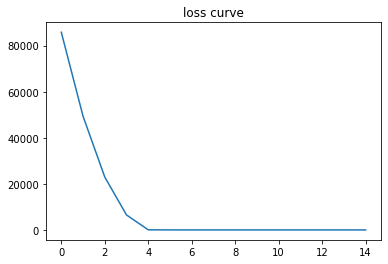

In [27]:
U,V,W,loss_curve = train(U,V,W,X,Y,X_validation,Y_validation)
# plot the loss-curve
plt.plot(loss_curve)
plt.title('loss curve')

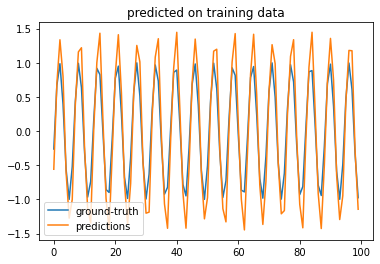

In [28]:
# predictions on the training set
predictions = []
for i in range(Y.shape[0]):
    x,y = X[i],Y[i]
    prev_activation = np.zeros((hidden_dim,1))
    # forward pass
    for timestep in range(seq_len):
        #new_input = np.zeros(x.shape)
        #new_input[timestep] = x[timestep]
        mul_u = np.dot(U,x)
        mul_w = np.dot(W,prev_activation)
        _sum = mul_u + mul_w
        activation = sigmoid(_sum)
        mul_v = np.dot(V,activation)
        prev_activation = activation
    predictions.append(mul_v)
    
# turn it into numpy array
predictions = np.array(predictions)
plt.plot(Y,label = 'ground-truth')
plt.plot(np.ravel(predictions),label = 'predictions')
plt.legend()
plt.title('predicted on training data')
plt.show()

In [30]:
print(U.shape)
U

(100, 50)


array([[0.51020213, 0.38454352, 0.32522486, ..., 0.93124478, 0.12612873,
        0.82210848],
       [0.68920413, 0.30450805, 0.50411811, ..., 0.68121313, 0.86247416,
        0.32384487],
       [0.97746338, 0.81701092, 0.87451307, ..., 0.78223606, 0.42371633,
        0.16965581],
       ...,
       [0.57682602, 0.19356935, 0.62959588, ..., 0.05059416, 0.483071  ,
        0.43615602],
       [0.42413143, 0.50934263, 0.14847796, ..., 0.91001644, 0.43190853,
        0.13902794],
       [0.42048535, 0.86141492, 0.83503202, ..., 0.83566333, 0.76387221,
        0.14843826]])

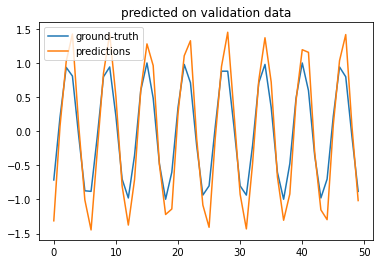

In [31]:
# predictions on the training set
val_predictions = []
for i in range(Y_validation.shape[0]):
    x,y = X_validation[i],Y_validation[i]
    prev_activation = np.zeros((hidden_dim,1))
    # forward pass
    for timestep in range(seq_len):
        #new_input = np.zeros(x.shape)
        #new_input[timestep] = x[timestep]
        mul_u = np.dot(U,x)
        mul_w = np.dot(W,prev_activation)
        _sum = mul_u + mul_w
        activation = sigmoid(_sum)
        mul_v = np.dot(V,activation)
        prev_activation = activation
    val_predictions.append(mul_v)
    
# turn it into numpy array
val_predictions = np.array(val_predictions)
plt.plot(Y_validation,label = 'ground-truth')
plt.plot(np.ravel(val_predictions),label = 'predictions')
plt.legend()
plt.title('predicted on validation data')
plt.show()

### build RNN model from scratch apply for music wave 

`(number_of_records x length_of_sequence x types_of_sequences)`
Here types_of_sequences is 1, because we have only one type of sequence - the sine wave

`(number_of_records x types_of_sequences` where type of sequences is 1

In [32]:
%pylab inline

import math

Populating the interactive namespace from numpy and matplotlib


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:159: UserWarning: pylab import has clobbered these variables: ['tanh']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


200


Text(0.5, 1.0, '')

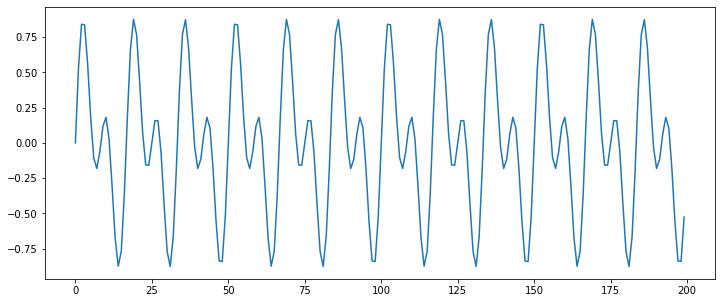

In [33]:
f = 30
seq_wave = np.array([(0.5 * math.sin(1*f*2*np.pi*x) + 0.5 * math.sin(2*f*2*np.pi*x)) for x in np.arange(0,0.4,0.002)])
print(len(seq_wave))
# visualize the seq wave
fig = plt.figure(figsize = (12.,5.))
plt.plot(seq_wave)
plt.title('')

In [34]:
# training dataset
X = []
Y = []
seq_len = 50
num_records = len(seq_wave) - seq_len
print(f'seq_len: {seq_len}')
print(f'num_records: {num_records}')
for i in range(num_records- 50):
    X.append(seq_wave[i:i+seq_len])
    Y.append(seq_wave[i+seq_len])
X = np.array(X)
Y = np.array(Y)
print(f'X.shape before: {X.shape}')
print(f'Y.shape before: {Y.shape}')
X = np.expand_dims(X,axis = 2)
Y = np.expand_dims(Y,axis =1 )
print(f'X.shape after: {X.shape}')
print(f'Y.shape after: {Y.shape}')

seq_len: 50
num_records: 150
X.shape before: (100, 50)
Y.shape before: (100,)
X.shape after: (100, 50, 1)
Y.shape after: (100, 1)


In [35]:
# validation dataset
X_val = []
Y_val = []
seq_len = 50

for i in range(num_records- 50,num_records):
    X_val.append(seq_wave[i:i+seq_len])
    Y_val.append(seq_wave[i+seq_len])
X_val = np.array(X_val)
Y_val = np.array(Y_val)
print(f'X_val.shape before: {X_val.shape}')
print(f'Y_val.shape before: {Y_val.shape}')
X_val = np.expand_dims(X_val,axis = 2)
Y_val = np.expand_dims(Y_val,axis =1 )
print(f'X_val.shape after: {X_val.shape}')
print(f'Y_val.shape after: {Y_val.shape}')

X_val.shape before: (50, 50)
Y_val.shape before: (50,)
X_val.shape after: (50, 50, 1)
Y_val.shape after: (50, 1)


Text(0.5, 1.0, 'full data')

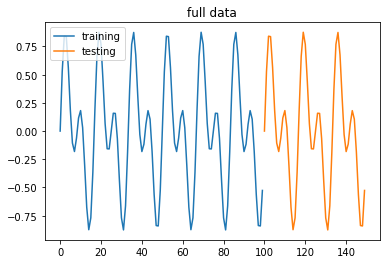

In [36]:
# display full dataset
plt.plot(range(len(X)),Y,label = 'training')
plt.plot(range(len(X),len(X)+len(X_val)),Y_val,label = 'testing')
plt.legend()
plt.title("full data")

- `U` is the weight matrix for weights between input and hidden layers

- `V` is the weight matrix for weights between hidden and ouput layers

- `W` is the weight matrix for shared weights in the RNN layer (hidden layer)

### References

https://www.youtube.com/watch?v=IV8--Y3evjw&t=565s

https://www.youtube.com/watch?v=V5zzNYSTFD4

https://stanford.edu/~shervine/teaching/cs-230/cheatsheet-recurrent-neural-networks

https://github.com/pangolulu/rnn-from-scratch

https://www.analyticsvidhya.com/blog/2019/01/fundamentals-deep-learning-recurrent-neural-networks-scratch-python/

https://pythonalgos.com/build-a-recurrent-neural-network-from-scratch-in-python-3/

https://github.com/ytang07/nn_examples

https://www.geeksforgeeks.org/ml-back-propagation-through-time/

https://datascience-enthusiast.com/DL/Building_a_Recurrent_Neural_Network-Step_by_Step_v1.html

https://programmerclick.com/article/6311154230/

https://www.datacamp.com/tutorial/tutorial-for-recurrent-neural-network

https://songhuiming.github.io/pages/2017/08/20/build-recurrent-neural-network-from-scratch/

http://songhuiming.github.io/functions/archives.html
